In [7]:
from jqdata import jy
from jqdata import *
from jqfactor import Factor, calc_factors, get_factor_values
import datetime
import calendar
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import scipy.stats as st
# from CAL.PyCAL import *    # CAL.PyCAL中包含font
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [8]:
days = get_trade_days('2011-01-01','2019-12-31')
days.size

2189

In [9]:
def get_zz_quote(code,end_date=None,count=None,start_date=None):
    '''获取3个指数的历史行情,返回panel结构（以日期、股指code的tuple为index）；日期：2011-01-01至2016-06-29'''
    if isinstance(code,str):
        code=[code]
    code.sort()
    code = [x[:6] for x in code]
    days = get_trade_days(start_date,end_date,count)
    code_df = jy.run_query(query(jy.SecuMain.InnerCode,jy.SecuMain.SecuCode,jy.SecuMain.ChiName)\
            .filter(jy.SecuMain.SecuCode.in_(code)).order_by(jy.SecuMain.SecuCode))
    df = jy.run_query(query(jy.QT_CSIIndexQuote).filter(jy.QT_CSIIndexQuote.IndexCode.in_(code_df.InnerCode),\
        jy.QT_CSIIndexQuote.TradingDay.in_(days),))
    df2  = pd.merge(code_df, df, left_on='InnerCode',right_on='IndexCode').set_index(['TradingDay','SecuCode'])
    df2.drop(['InnerCode','IndexCode','ID','UpdateTime','JSID','OpenInterest','SettleValue','IndexCSIType'],axis=1,inplace=True)
#     index = pd.MultiIndex.from_product([(tuple(days)), tuple(['000300', '000905', '000906'])], names = ['TradingDay', 'SecuCode'])
#     return pd.DataFrame(df2, index = index)
#     df2.stack(level = ['TradingDay', 'SecuCode'])
    return df2.to_panel()
#     return df2

panel_1 = get_zz_quote(['000300.XSHG','000905.XSHG','000906.XSHG'],start_date='2011-01-01',end_date='2016-06-29')
panel_1 = panel_1.to_frame(False)
# print(panel_1)
# panel_1.pivot(index = 'TradingDay')
# panel_1.stack('SecuCode')
panel_1.tail(15)

/opt/conda/lib/python3.6/site-packages/sqlalchemy/dialects/mysql/base.py:1942: SAWarning: MariaDB (10, 2, 6) before 10.2.9 has known issues regarding CHECK constraints, which impact handling of NULL values with SQLAlchemy's boolean datatype (MDEV-13596). An additional issue prevents proper migrations of columns with CHECK constraints (MDEV-11114).  Please upgrade to MariaDB 10.2.9 or greater, or use the MariaDB 10.1 series, to avoid these issues.
  "series, to avoid these issues." % (mdb_version, ))
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



ChiName       ...        PrevClosePrice
TradingDay SecuCode                  ...                      
2016-06-23 000300      沪深300指数       ...             3133.9611
           000905    中证小盘500指数       ...             6008.8857
           000906      中证800指数       ...             3637.1692
2016-06-24 000300      沪深300指数       ...             3117.3168
           000905    中证小盘500指数       ...             5978.1737
           000906      中证800指数       ...             3618.0710
2016-06-27 000300      沪深300指数       ...             3077.1554
           000905    中证小盘500指数       ...             5903.6202
           000906      中证800指数       ...             3571.9073
2016-06-28 000300      沪深300指数       ...             3120.5443
           000905    中证小盘500指数       ...             6044.2191
           000906      中证800指数       ...             3632.7159
2016-06-29 000300      沪深300指数       ...             3136.4013
           000905    中证小盘500指数       ...             6107.5105
           000906      中证800指数       ...             3657.1072

[15 rows x 15 columns]

In [10]:
'''日期：2016-06-30至2019-12-31'''
panel_2 = get_zz_quote(['000300.XSHG','000905.XSHG','000906.XSHG'],start_date='2016-06-30',end_date='2019-12-31')
panel_2 = panel_2.to_frame(False)
panel_2.tail(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



ChiName       ...        PrevClosePrice
TradingDay SecuCode                  ...                      
2019-12-25 000300      沪深300指数       ...             3992.9581
           000905    中证小盘500指数       ...             5162.0702
           000906      中证800指数       ...             4175.6363
2019-12-26 000300      沪深300指数       ...             3990.8671
           000905    中证小盘500指数       ...             5183.0986
           000906      中证800指数       ...             4178.0241
2019-12-27 000300      沪深300指数       ...             4025.9879
           000905    中证小盘500指数       ...             5219.1404
           000906      中证800指数       ...             4212.9472
2019-12-30 000300      沪深300指数       ...             4022.0278
           000905    中证小盘500指数       ...             5179.1929
           000906      中证800指数       ...             4202.0933
2019-12-31 000300      沪深300指数       ...             4081.6334
           000905    中证小盘500指数       ...             5241.9383
           000906      中证800指数       ...             4261.6674

[15 rows x 15 columns]

观察结论1：

In [11]:
'''融合两个panel -> 日期：2011-01-01至2019-12-31'''
panel = pd.concat([panel_1, panel_2])[['ChiName', 'ClosePrice', 'PrevClosePrice']]
panel.iloc[:20, :]

ChiName  ClosePrice  PrevClosePrice
TradingDay SecuCode                                       
2011-01-04 000300      沪深300指数    3189.680        3128.260
           000905    中证小盘500指数    5011.498        4936.716
           000906      中证800指数    3507.006        3443.576
2011-01-05 000300      沪深300指数    3175.660        3189.680
           000905    中证小盘500指数    5028.766        5011.498
           000906      中证800指数    3499.012        3507.006
2011-01-06 000300      沪深300指数    3159.640        3175.660
           000905    中证小盘500指数    5001.283        5028.766
           000906      中证800指数    3480.962        3499.012
2011-01-07 000300      沪深300指数    3166.620        3159.640
           000905    中证小盘500指数    4975.144        5001.283
           000906      中证800指数    3481.632        3480.962
2011-01-10 000300      沪深300指数    3108.190        3166.620
           000905    中证小盘500指数    4830.562        4975.144
           000906      中证800指数    3407.419        3481.632
2011-01-11 000300      沪深300指数    3124.920        3108.190
           000905    中证小盘500指数    4804.822        4830.562
           000906      中证800指数    3415.995        3407.419
2011-01-12 000300      沪深300指数    3142.340        3124.920
           000905    中证小盘500指数    4833.580        4804.822

In [12]:
def all_present_percentage():
    '''检查在3个指数均有记录的交易日的比例'''
    all_present = 0
    for i in range(len(days)):
        if panel.loc[str(days[i]), :].shape[0] == 3:
            all_present += 1
    print(panel.loc[str(days[0]), :])
    return all_present / len(days)

all_present_percentage()

                       ChiName  ClosePrice  PrevClosePrice
TradingDay SecuCode                                       
2011-01-04 000300      沪深300指数    3189.680        3128.260
           000905    中证小盘500指数    5011.498        4936.716
           000906      中证800指数    3507.006        3443.576


1.0

结论：$2011/01/01$至$2019/12/31$的所有交易日均有3个股指的记录。

In [13]:
# def run_test(df, index_1, index_2):
#     for i in range(df.iloc[0, :].shape[0]):
#         df['TradingDay'][i]
def run_test(index_1, index_2):
    '''对3个指数两两进行游程检验，研究其相关性'''
    n1 = 0
    n2 = 0
    runs = 0
    comparison_prev = None
    for i in range(1, len(days)):
        try:
            clp_1 = panel['ClosePrice'][str(days[i]), index_1] / panel['ClosePrice'][str(days[i - 1]), index_1] - 1
            clp_2 = panel['ClosePrice'][str(days[i]), index_2] / panel['ClosePrice'][str(days[i - 1]), index_2] - 1
            if clp_1 > clp_2:
                n1 += 1
                comparison = '>'
            elif clp_1 < clp_2:
                n2 += 1
                comparison = '<'
            else:
                comparison = '='
                print('==')
            if comparison != comparison_prev:
                runs += 1
            comparison_prev = comparison
        except KeyError:
            pass
#     print(n1, n2, runs)
    X = 2 * n1 * n2 / (n1 + n2) + 1
    std = np.sqrt((2 * n1 * n2) * (2 * n1 * n2 - n1 - n2) / ((n1 + n2)**2 * (n1 + n2 - 1)))
    # z是该分布经Lindburg-Levy变换后（服从了标准正态分布）的新分布的标准差
    Z = (abs(X - runs) - 0.5) / std
    return n1, n2, runs, std, X, Z

In [14]:
run_test('000300', '000905')

(1006, 1182, 975, 23.231319081243292, 1087.9213893967094, 4.839216791933144)

结论：$Z$已经比标准正态分布（完全随机的两个股指增长率的相对大小的分布）的标准差$\sigma = 1$大了很多，这说明“沪深300指数”和“中证小盘500指数”是存在一定的相关性的。

In [15]:
run_test('000300', '000906')

(1006, 1182, 975, 23.231319081243292, 1087.9213893967094, 4.839216791933144)

结论：$Z$已经比标准正态分布（完全随机的两个股指增长率的相对大小的分布）的标准差$\sigma = 1$大了很多，这说明“沪深300指数”和“中证小盘800指数”是存在一定的相关性的。

In [16]:
run_test('000905', '000906')

(1182, 1006, 975, 23.231319081243292, 1087.9213893967094, 4.839216791933144)

In [17]:
panel = panel.unstack()['ClosePrice']

In [18]:
panel.tail(6)

SecuCode,000300,000905,000906
TradingDay,,,
2019-12-24,3992.9581,5162.0702,4175.6363
2019-12-25,3990.8671,5183.0986,4178.0241
2019-12-26,4025.9879,5219.1404,4212.9472
2019-12-27,4022.0278,5179.1929,4202.0933
2019-12-30,4081.6334,5241.9383,4261.6674
2019-12-31,4096.5821,5267.6622,4278.5332


结论：$Z$已经比标准正态分布（完全随机的两个股指增长率的相对大小的分布）的标准差$\sigma = 1$大了很多，这说明“中证小盘500指数”和“中证小盘800指数”是存在一定的相关性的。

In [19]:
def second_Friday(year, month):
    c = calendar.Calendar(firstweekday=calendar.SUNDAY)
    month_calendar = c.monthdatescalendar(year,month)
    second_friday = [day for week in month_calendar for day in week if \
                    day.weekday() == calendar.FRIDAY and \
                    day.month == month][1]
    return str(pd.to_datetime(second_friday))
second_Friday(2020, 6)

'2020-06-12 00:00:00'

In [20]:
df = pd.concat(get_factor_values(['000001.XSHE'], ['size', 'beta', 'momentum', 'residual_volatility','non_linear_size',\
            'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'], '2019-10-01', '2019-12-01').values(), axis = 1).mean(axis = 1)
df

2019-10-08    0.277756
2019-10-09    0.278965
2019-10-10    0.274095
2019-10-11    0.272117
2019-10-14    0.269089
2019-10-15    0.270299
2019-10-16    0.276950
2019-10-17    0.275942
2019-10-18    0.276912
2019-10-21    0.271597
2019-10-22    0.364949
2019-10-23    0.357047
2019-10-24    0.347712
2019-10-25    0.354983
2019-10-28    0.365559
2019-10-29    0.356226
2019-10-30    0.364219
2019-10-31    0.381678
2019-11-01    0.379725
2019-11-04    0.382397
2019-11-05    0.375310
2019-11-06    0.389462
2019-11-07    0.397601
2019-11-08    0.400694
2019-11-11    0.411846
2019-11-12    0.414364
2019-11-13    0.403001
2019-11-14    0.392747
2019-11-15    0.380182
2019-11-18    0.373685
2019-11-19    0.386415
2019-11-20    0.393714
2019-11-21    0.392003
2019-11-22    0.407376
2019-11-25    0.403877
2019-11-26    0.385987
2019-11-27    0.391128
2019-11-28    0.375346
2019-11-29    0.372974
Freq: B, dtype: float64

In [21]:
def Barra_10(code):
    columns = ['size', 'beta', 'momentum', 'residual_volatility','non_linear_size',\
            'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage']
    ret = pd.DataFrame(columns = columns)
    for i in range(106):
        if i % 6 == 0:
            date = pd.to_datetime(1300000000 + 86400 * 183 * (i // 6), unit='s')
            stocks = get_index_stocks(code, date = date)
#         print(stocks)
        num = len(stocks)
    #     set_universe(stocks)
        barra_10 = pd.DataFrame(columns = columns)
        start_date = second_Friday(2011 + i // 12, i + 1 - (i // 12) * 12)
        end_date = second_Friday(2011 + (i + 1) // 12, (i + 1 - (i // 12) * 12) % 12 + 1)
#         print(start_date, end_date)
        for column in columns:
            barra_10[column] = pd.concat(get_factor_values(stocks, column, start_date, end_date).values(), axis = 1).mean(axis = 1)
        ret = pd.concat([ret, barra_10])
    return ret

df_barra_10 = Barra_10('000300.XSHG')

In [22]:
df_barra_10.shape

(2245, 10)

In [23]:
df_panel = panel.loc[list(x for x in df_barra_10.index), panel.columns]
df_panel.shape

(2245, 3)

In [139]:
train = pd.concat([df_panel, df_barra_10], axis = 1).iloc[:-300, :]
print(train.shape)
train.tail(6)

(1945, 13)


,000300,000905,000906,size,beta,momentum,residual_volatility,non_linear_size,book_to_price_ratio,liquidity,earnings_yield,growth,leverage
TradingDay,,,,,,,,,,,,,
2018-08-22,3307.9545,4837.0183,3562.5763,0.357935,0.133829,-0.125916,0.071664,-0.233003,-0.084866,0.161754,-0.216529,0.055910,-0.011102
2018-08-23,3320.0257,4863.6651,3577.2134,0.358795,0.130118,-0.135000,0.069818,-0.232482,-0.081757,0.156321,-0.214087,0.055826,-0.007111
2018-08-24,3325.3347,4852.2887,3579.4487,0.357162,0.136675,-0.148677,0.068959,-0.229148,-0.085929,0.155085,-0.211237,0.056720,-0.013687
2018-08-27,3406.5735,4960.0655,3664.9368,0.355275,0.135764,-0.159495,0.058438,-0.227028,-0.078314,0.146308,-0.207467,0.056528,-0.006216
2018-08-28,3400.1705,4974.2072,3662.3174,0.358537,0.134644,-0.163786,0.062491,-0.231249,-0.082787,0.148569,-0.211443,0.055387,-0.000982
2018-08-29,3386.5736,4941.9607,3645.4240,0.358955,0.134910,-0.167152,0.069156,-0.231768,-0.088795,0.154690,-0.196349,0.054979,0.001135


In [140]:
test = pd.concat([df_panel, df_barra_10], axis = 1).iloc[-300:, :]
print(test.shape)
test.tail(6)

(300, 13)


,000300,000905,000906,size,beta,momentum,residual_volatility,non_linear_size,book_to_price_ratio,liquidity,earnings_yield,growth,leverage
TradingDay,,,,,,,,,,,,,
2019-11-01,3952.3872,4962.3495,4105.0419,0.366459,0.222185,-0.124961,-0.076960,-0.270453,-0.060086,0.076296,-0.072981,-0.015391,-0.016152
2019-11-04,3978.1216,4987.8364,4130.4730,0.363230,0.218118,-0.133517,-0.082787,-0.266847,-0.058212,0.077105,-0.074908,-0.016373,-0.015415
2019-11-05,4002.8128,5025.3029,4157.3479,0.360288,0.219684,-0.129502,-0.081101,-0.264157,-0.060842,0.079108,-0.074836,-0.017732,-0.018450
2019-11-06,3984.8816,4974.7343,4133.3873,0.358456,0.220887,-0.134998,-0.074942,-0.261777,-0.063277,0.082758,-0.077247,-0.020711,-0.021507
2019-11-07,3991.8749,5007.0666,4145.1308,0.361972,0.216138,-0.143200,-0.074775,-0.267128,-0.062089,0.084725,-0.077060,-0.020244,-0.017649
2019-11-08,3973.0107,4988.2938,4126.4724,0.363638,0.213688,-0.140527,-0.073354,-0.268114,-0.058605,0.087036,-0.075948,-0.021695,-0.013152


In [169]:
def k_fold_cross_validation(k, is_train = True):
#     global train, test
#     for column in train.columns:
#         train[column] = train[column].apply(float)
#     for column in test.columns:
#         test[column] = test[column].apply(float)
    if is_train:
        X_train = []
        y_train = []
        for i in range(60, len(train)):
            X_train.append(train.iloc[i - 60 : i, :1].as_matrix())
            y_train.append(train.iloc[i, :1].as_matrix())
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        print(X_train.shape, type(X_train))
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#         y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
        print(X_train.shape, y_train.shape)
        return X_train, y_train
    else:
        X_test = []
        y_test = []
        for i in range(60, len(test)):
            X_test.append(test.iloc[i - 60 : i, :1].as_matrix())
            y_test.append(test.iloc[i, :1].as_matrix())
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#         y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))
        print(X_test.shape, y_test.shape)
        return X_test, y_test

In [100]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [170]:
X_train, y_train = k_fold_cross_validation(10)
X_test, y_test = k_fold_cross_validation(10, False)
# sc = MinMaxScaler(feature_range=(0, 1))
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


(1885, 60, 1) <class 'numpy.ndarray'>
(1885, 60, 1) (1885, 1)
(240, 60, 1) (240, 1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [163]:
# X_train

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = Adam(lr = 1e-1, beta_1 = 0.9, beta_2 = 0.999, epsilon  = 1e-7, decay = 1e-6), loss = 'mean_absolute_error')
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

In [564]:
# params = {
#     'booster': 'gbtree',
#     'objective': 'multi:softmax',
#     'eval_metric': 'mlogloss',
#     'num_class': 3,
#     'gamma': 0.1,
#     'max_depth': 6,
#     'lambda': 2,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3,
#     'silent': 1,
#     'eta': 0.1,
#     'seed': 42,
#     'nthread': 4,
# }

# l_param = params.items()

k = 10
X_train, y_train = k_fold_cross_validation(k, True)
X_test, y_test = k_fold_cross_validation(k, False)
# print(X_train[0].shape, y_train[0].shape)
# dict_model = {}
y_pred = {}

# Check failed: preds.Size() == (static_cast<size_t>(param_.num_class) * info.labels_.Size()) 
# SoftmaxMultiClassObj: label size and pred size does not match\


for code in ['000300', '000905', '000906']:
#     dict_model[code] = []
# 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='reg:linear'", "booster='gbtree'",\
# 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1',\
# 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0',\
# 'seed=None', 'missing=None', '**kwargs'
    reg = xgb.XGBRegressor(max_depth = 20, learning_rate = 0.1, n_estimators = 1000, objective = 'reg:linear',\
                          nthread = 4, gamma = 0, min_child_weight = 1, subsample = 0.9, colsample_bytree = 0.7,\
                          reg_lambda = 300, eta = 0.05, num_class = 1)
    for i in range(k):
#         dtrain = xgb.DMatrix(X_train[i], y_train[i][code])
#         num_rounds = 500
        reg.fit(X_train[i], y_train[i].loc[:, code], eval_set=[(X_train[i], y_train[i].loc[:, code]), (X_test, y_test.loc[:, code])], early_stopping_rounds=50)
#         model = xgb.train(l_param, dtrain, num_rounds)
#         dict_model[code].append(model)
    y_pred[code] = pd.DataFrame(reg.predict(X_test), index = test.index[(5 * k) : (-51 + 5 * k)])

# for code in ['000300', '000905', '000906']:
#     dict_model[code] = []
#     model = sum(dict_model[code]) / k
#     # 对测试集进行预测
#     dtest = xgb.DMatrix(X_test)
#     ans = model.predict(dtest)
#     plt.plot(pd.concat(X_test[code], y_test[code]))
#     plt.plot(ans)

(1895, 13) (50, 3)
(250, 13) (50, 3)


XGBoostError: b'[01:33:10] /workspace/src/objective/regression_obj.cu:66: Check failed: preds.Size() == info.labels_.Size() (1445 vs. 500) labels are not correctly providedpreds.size=1445, label.size=500\n\nStack trace returned 10 entries:\n[bt] (0) /opt/conda/xgboost/libxgboost.so(dmlc::StackTrace()+0x3d) [0x7fb2ae50f5cd]\n[bt] (1) /opt/conda/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7fb2ae50f9c8]\n[bt] (2) /opt/conda/xgboost/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LinearSquareLoss>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x1c3) [0x7fb2ae706e03]\n[bt] (3) /opt/conda/xgboost/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x362) [0x7fb2ae5861e2]\n[bt] (4) /opt/conda/xgboost/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7fb2ae507ab5]\n[bt] (5) /opt/conda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fb303424ec0]\n[bt] (6) /opt/conda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fb30342487d]\n[bt] (7) /opt/conda/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fb30363ae4e]\n[bt] (8) /opt/conda/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13885) [0x7fb30363b885]\n[bt] (9) /opt/conda/bin/python(_PyObject_FastCallDict+0x8b) [0x5624c93c45bb]\n\n'

In [532]:
test.loc[:, '000300'].tail(6)
test.index.shape

(300,)

In [533]:
type(y_pred['000300'])

pandas.core.frame.DataFrame

000300 的RMSE: 502630.7499057249
000300 的MAE: 607.727761761107
000300 的R^2值: -3.973341761874538
000905 的RMSE: 394080.3286210312
000905 的MAE: 461.17860989740205
000905 的R^2值: -0.9189758809751187
000906 的RMSE: 385652.1868058964
000906 的MAE: 455.51897260604915
000906 的R^2值: -1.4980636251109982


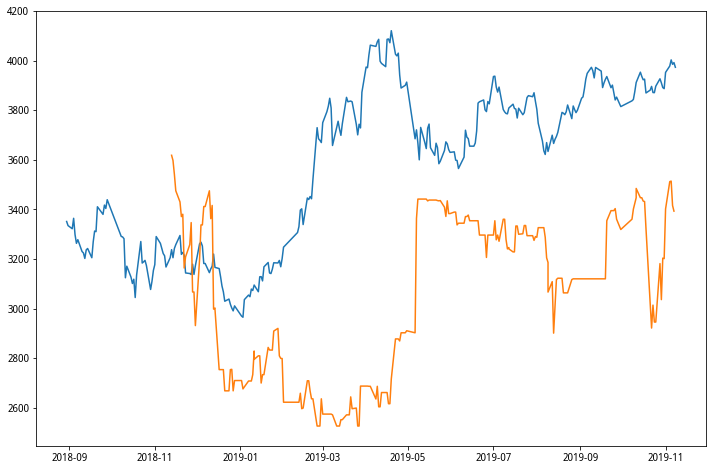

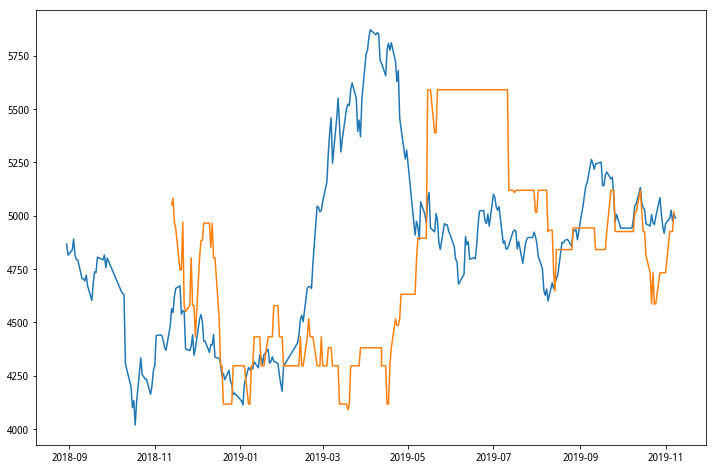

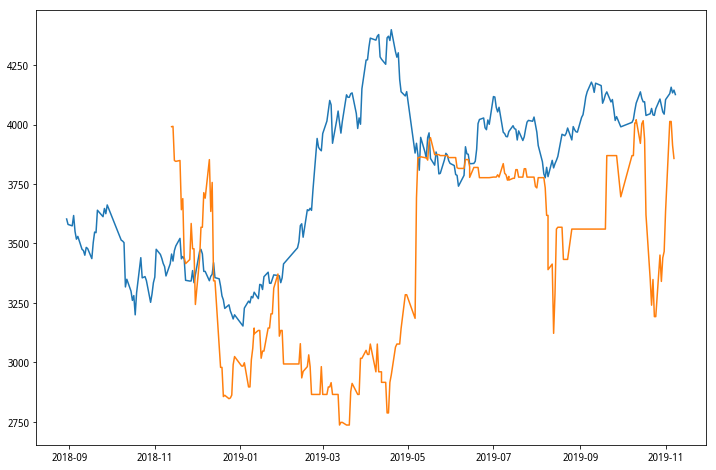

In [557]:
# 计算准确率
for code in ['000300', '000905', '000906']:
    print(code, '的RMSE:', mean_squared_error(y_pred[code], y_test[code]))
    print(code, '的MAE:', mean_absolute_error(y_pred[code], y_test[code]))
    print(code, '的R^2值:', r2_score(y_pred[code], y_test[code]))
    fig = plt.figure(figsize = (12, 8))
    plt.plot(test.loc[:, code])
    plt.plot(y_pred[code])
# cnt_1 = 0
# cnt_2 = 0
# for i in range(len(y_test)):
#     if ans[i] == y_test[i]:
#         cnt1 += 1
#     else:
#         cnt2 += 1

# print("Accuracy: %.2f %% " % (100 * cnt_1 / (cnt_1 + cnt_2)))

# 显示重要特征
# plot_importance(model)
# plt.show()

In [ ]:
xgboost_predict(train, evaluation)

In [ ]:
#导入库函数
import numpy 
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#读取数据
data= read_csv('data_s.csv') #csv文件 n*1 ,n代表样本数，反应时间序列，1维数据
values1 = data.values;
dataset=values1[:,0].reshape(-1,1)#注意将一维数组，转化为2维数组
dataset = dataset.astype('float32')#将数据转化为32位浮点型，防止0数据 
                  
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):#后一个数据和前look_back个数据有关系
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a) #.apeend方法追加元素
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY) #生成输入数据和输出数据 
 
numpy.random.seed(7)#随机数生成时算法所用开始的整数值
 
 
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))#归一化0-1
dataset = scaler.fit_transform(dataset)
# split into train and test sets  #训练集和测试集分割
train_size = int(len(dataset) * 0.67)#%67的训练集，剩下测试集
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]#训练集和测试集
 
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX , trainY = create_dataset(train, look_back)#训练输入输出
testX,testY=create_dataset(test, look_back)#测试输入输出
 
 
 #reshape input to be [samples, time steps, features]#注意转化数据维数
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
 
#建立LSTM模型
model = Sequential()
model.add(LSTM(11, input_shape=(1, look_back)))#隐层11个神经元 （可以断调整此参数提高预测精度）
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')#评价函数mse，优化器adam
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)#100次迭代 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#数据反归一化
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
 
 
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
 
plt.figure(figsize=(20,6))
l1,=plt.plot(scaler.inverse_transform(dataset),color='red',linewidth=5,linestyle='--')
l2,=plt.plot(trainPredictPlot,color='k',linewidth=4.5)
l3,=plt.plot(testPredictPlot,color='g',linewidth=4.5)
plt.ylabel('Height m')
plt.legend([l1,l2,l3],('raw-data','true-values','pre-values'),loc='best')
plt.title('LSTM Gait Prediction')
plt.show()